In [ ]:
!git clone https://github.com/sameerpixelbot/Anomaly_Transformer.git

Cloning into 'Anomaly_Transformer'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 42 (delta 23), reused 33 (delta 14), pack-reused 0
Unpacking objects: 100% (42/42), done.


In [ ]:
cd Anomaly_Transformer/

/content/Anomaly_Transformer


In [ ]:
from transformer import Transformer
import pandas as pd

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

In [ ]:
num_layers=6
d_model=128
num_heads=8
num_parts=4
dff=128
target_size=128
num_of_outputs=60

In [ ]:
trans=Transformer(num_layers=num_layers,d_model=d_model,num_heads=num_heads,num_parts=num_parts,dff=dff,target_size=target_size,num_of_outputs=num_of_outputs)


loss functions and optimizers 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model=128)

optimizer = tf.keras.optimizers.Adam(0.00001, beta_1=0.91, beta_2=0.98, 
                                     epsilon=1e-9)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False,name='loss_object')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  
  #loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

  # train_loss.update_state(real,pred)
  # loss=train_loss.result()
  # return loss


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.cast(tf.argmax(pred, axis=0), dtype=tf.dtypes.float32))
  print(accuracies)
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  print(mask)
  accuracies = tf.math.logical_and(mask, accuracies)
  print(accuracies)
  
  accuracies = tf.cast(accuracies, dtype=tf.float32)
  print(accuracies)
  mask = tf.cast(mask, dtype=tf.float32)
  print(accuracies)

  print(tf.reduce_sum(accuracies))
  print(tf.reduce_sum(mask))
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=trans,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [ ]:
EPOCHS = 200

In [ ]:
train_step_signature = [
    tf.TensorSpec(shape=(15,34), dtype=tf.float32),
    tf.TensorSpec(shape=(1,60), dtype=tf.float32),
]


def train_step(inp, tar):
  
  with tf.device('/device:GPU:0'):
    with tf.GradientTape() as tape:
      predictions, _ = trans(inp, True)
      #predictions=predictions[0]
      #print(predictions)
      loss = loss_function(tar, predictions)
      # train_loss.update_state(tar,predictions)
      # loss=train_loss.result()
      #print(loss)
    gradients = tape.gradient(loss, trans.trainable_variables)
    
    optimizer.apply_gradients(zip(gradients, trans.trainable_variables))
    
    train_loss(loss)
    # a=accuracy_function(tar, predictions)
    # print(a)
    train_accuracy.update_state(tar,predictions)

tf.function(func=train_step, input_signature=train_step_signature)

In [ ]:
# df=pd.read_csv('/content/gdrive/MyDrive/data1.csv',header=None)
# #df=df.iloc[:500]
# test=df[(df[45]==1) | (df[46]==1) | (df[64]==1) | (df[78]==1) | (df[79]==1) | (df[80]==1) | (df[85]==1)]
# test2=test[[45,46,64,78,79,80,85]]
# from sklearn.preprocessing import MinMaxScaler
# scale=MinMaxScaler()
# b=scale.fit_transform(test.iloc[:,4:38])
# temp=pd.DataFrame(b)

In [ ]:
df=pd.read_csv('/content/gdrive/MyDrive/data1.csv',header=None)
#df=df.iloc[:500]
#test=df[(df[45]==1) | (df[46]==1) | (df[64]==1) | (df[78]==1) | (df[79]==1) | (df[80]==1) | (df[85]==1)]
#test2=test[[45,46,64,78,79,80,85]]
df=df.iloc[::3,:].reset_index().drop('index',axis=1)
test2=df.iloc[:,38:]
from sklearn.preprocessing import MinMaxScaler
scale=MinMaxScaler()
#b=scale.fit_transform(test.iloc[:,4:38])
b=scale.fit_transform(df.iloc[:,4:38])
temp=pd.DataFrame(b)
temp.insert(34,34,df[1].reset_index()[1])
temp=temp.join(test2.reset_index().drop('index',axis=1))
group_list=[]
for groups in temp.groupby(34):
    group_list.append(pd.DataFrame(groups[1]))
padding=pd.DataFrame(np.zeros((1,len(temp.iloc[0]))),columns=temp.columns)
threshold=15
x_train=[]
for group in group_list:
    if threshold<len(group[0]):
        x_train.append(group[-1*threshold:])
        continue
    for i in range(len(group[0]),threshold):
      group=group.append(padding,ignore_index=True) 
    x_train.append(group)
x_train_final=[]
y_train=[]
for i in range(1,len(x_train)):
  x_train_temp=tf.constant(x_train[i].iloc[:,:34].values,shape=(15,34),dtype='float32')
  x_train_final.append(x_train_temp)
  y_train_temp=tf.constant(x_train[i].iloc[:,-60:].iloc[0].values,shape=(1,60),dtype='float32')
  y_train.append(y_train_temp)

In [ ]:
scale.transform

In [ ]:
df=pd.read_csv('/content/gdrive/MyDrive/data6.csv',header=None)
#df=df.iloc[:500]
#test=df[(df[45]==1) | (df[46]==1) | (df[64]==1) | (df[78]==1) | (df[79]==1) | (df[80]==1) | (df[85]==1)]
#test2=test[[45,46,64,78,79,80,85]]
#df=df.iloc[::3,:].reset_index().drop('index',axis=1)
test2=df.iloc[:,38:]
#from sklearn.preprocessing import MinMaxScaler
#scale=MinMaxScaler()
#b=scale.fit_transform(test.iloc[:,4:38])
b=scale.transform(df.iloc[:,4:38])
temp=pd.DataFrame(b)
temp.insert(34,34,df[1].reset_index()[1])
temp=temp.join(test2.reset_index().drop('index',axis=1))
group_list=[]
for groups in temp.groupby(34):
    group_list.append(pd.DataFrame(groups[1]))
padding=pd.DataFrame(np.zeros((1,len(temp.iloc[0]))),columns=temp.columns)
threshold=15
x_train=[]
for group in group_list:
    if threshold<len(group[0]):
        x_train.append(group[-1*threshold:])
        continue
    for i in range(len(group[0]),threshold):
      group=group.append(padding,ignore_index=True) 
    x_train.append(group)
x_train_final=[]
y_train=[]
for i in range(1,len(x_train)):
  x_train_temp=tf.constant(x_train[i].iloc[:,:34].values,shape=(15,34),dtype='float32')
  x_train_final.append(x_train_temp)
  y_train_temp=tf.constant(x_train[i].iloc[:,-60:].iloc[0].values,shape=(1,60),dtype='float32')
  y_train.append(y_train_temp)

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  i=0
  while i<len(y_train):
    
    inp=x_train_final[i]
    tar=y_train[i]

    i+=1
    # print(tar)
    
    train_step(inp, tar)
    batch=i
    if batch % 60 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
      
  if (epoch + 1) % 2 == 0:
    ckpt_save_path = ckpt_manager.save()
    #trans.save(f'/content/gdrive/MyDrive/transformer/Transformer_{epoch+1}.h5')
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')
    
  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 60 Loss 0.1203 Accuracy 0.9833
Epoch 1 Batch 120 Loss 0.1129 Accuracy 0.9750
Epoch 1 Batch 180 Loss 0.1060 Accuracy 0.9667
Epoch 1 Batch 240 Loss 0.1435 Accuracy 0.9500
Epoch 1 Batch 300 Loss 0.1371 Accuracy 0.9500
Epoch 1 Batch 360 Loss 0.1393 Accuracy 0.9472
Epoch 1 Batch 420 Loss 0.1309 Accuracy 0.9476
Epoch 1 Batch 480 Loss 0.1214 Accuracy 0.9521
Epoch 1 Batch 540 Loss 0.1161 Accuracy 0.9537
Epoch 1 Batch 600 Loss 0.1138 Accuracy 0.9567
Epoch 1 Batch 660 Loss 0.1129 Accuracy 0.9561
Epoch 1 Batch 720 Loss 0.1138 Accuracy 0.9556
Epoch 1 Batch 780 Loss 0.1147 Accuracy 0.9538
Epoch 1 Batch 840 Loss 0.1078 Accuracy 0.9571
Epoch 1 Batch 900 Loss 0.1053 Accuracy 0.9578
Epoch 1 Batch 960 Loss 0.1016 Accuracy 0.9594
Epoch 1 Batch 1020 Loss 0.1062 Accuracy 0.9588
Epoch 1 Batch 1080 Loss 0.1037 Accuracy 0.9602
Epoch 1 Batch 1140 Loss 0.1113 Accuracy 0.9588
Epoch 1 Batch 1200 Loss 0.1185 Accuracy 0.9558
Epoch 1 Batch 1260 Loss 0.1216 Accuracy 0.9548
Epoch 1 Batch 1320 Loss 0.1283

KeyboardInterrupt: ignored

In [ ]:
trans=keras.models.load_model(path='/content/gdrive/MyDrive/Transformer_{epoch}.h5')

In [ ]:
trans.load_weights('/content/gdrive/MyDrive/datasets/model1.tf')

In [ ]:
trans.save_weights('/content/gdrive/MyDrive/datasets/model1.tf',save_format='tf')

In [ ]:
trans.save(f'/content/gdrive/MyDrive/Transformer_{epoch}.h5')

NameError: ignored

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
y_train

[<tf.Tensor: shape=(1, 60), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 60), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>]

In [ ]:
len(x_train_final)

2

In [ ]:
trans(x_train_final[1],False)

(<tf.Tensor: shape=(1, 60), dtype=float32, numpy=
 array([[3.5833725e-08, 1.3528295e-01, 5.2595561e-10, 4.7653620e-07,
         2.1735415e-08, 7.7349097e-01, 3.7585361e-09, 4.7678030e-05,
         2.4355384e-11, 1.4357494e-04, 6.9941814e-07, 6.1108616e-09,
         1.9997058e-06, 5.9208937e-06, 1.0246067e-09, 8.5392048e-06,
         7.1302153e-02, 5.9972663e-08, 1.9069955e-08, 1.5808304e-05,
         2.1948978e-07, 3.3565507e-06, 1.7669514e-05, 3.2074266e-07,
         4.2311308e-07, 3.2822971e-08, 5.1935960e-05, 3.4150988e-05,
         1.8087351e-06, 8.5740365e-05, 3.9705060e-07, 2.3764468e-08,
         2.5237495e-07, 7.0766193e-09, 1.9383310e-04, 1.1272426e-11,
         5.5739687e-08, 9.3651202e-04, 9.2922095e-03, 1.4021373e-04,
         1.5053498e-08, 2.6810443e-04, 4.0579224e-08, 5.6999294e-08,
         2.3445298e-05, 1.6066617e-06, 9.1088390e-09, 7.2309320e-10,
         5.0872181e-06, 2.0538141e-07, 1.7736039e-04, 1.7222525e-11,
         1.1063807e-03, 1.8040851e-12, 4.7532544e-06,

In [ ]:
df.iloc[::3,:].reset_index().drop('index',axis=1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97
0,0,1,0,1,1032.246094,334.863281,1042.792969,326.425781,1024.863281,325.371094,1063.886719,332.753906,1016.425781,328.535156,1081.816406,391.816406,1013.261719,381.269531,1105.019531,460.371094,1002.714844,438.222656,1048.066406,473.027344,1003.769531,463.535156,1061.777344,515.214844,1015.371094,513.105469,1063.886719,606.972656,1025.917969,604.863281,1063.886719,700.839844,1039.628906,693.457031,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,30,1,5,1,1031.191406,334.863281,1041.738281,326.425781,1024.863281,325.371094,1063.886719,332.753906,1015.371094,328.535156,1081.816406,391.816406,1013.261719,380.214844,1103.964844,460.371094,1002.714844,437.167969,1047.011719,473.027344,1002.714844,463.535156,1061.777344,515.214844,1015.371094,513.105469,1062.832031,608.027344,1025.917969,605.917969,1063.886719,701.894531,1039.628906,692.402344,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,60,1,10,1,1031.191406,334.863281,1041.738281,326.425781,1024.863281,325.371094,1063.886719,332.753906,1014.316406,328.535156,1081.816406,391.816406,1013.261719,380.214844,1103.964844,460.371094,1002.714844,437.167969,1047.011719,471.972656,1002.714844,463.535156,1061.777344,515.214844,1015.371094,513.105469,1062.832031,606.972656,1025.917969,605.917969,1063.886719,701.894531,1039.628906,692.402344,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,90,1,15,1,1030.136719,334.863281,1040.683594,325.371094,1023.808594,325.371094,1063.886719,332.753906,1013.261719,329.589844,1081.816406,391.816406,1013.261719,381.269531,1103.964844,460.371094,1001.660156,437.167969,1048.066406,473.027344,1002.714844,464.589844,1061.777344,515.214844,1015.371094,513.105469,1062.832031,608.027344,1025.917969,605.917969,1063.886719,700.839844,1039.628906,692.402344,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,120,1,20,1,1030.136719,334.863281,1040.683594,326.425781,1023.808594,325.371094,1062.832031,332.753906,1013.261719,330.644531,1081.816406,391.816406,1013.261719,381.269531,1105.019531,460.371094,1002.714844,437.167969,1048.066406,473.027344,1001.660156,466.699219,1061.777344,515.214844,1015.371094,513.105469,1062.832031,608.027344,1025.917969,605.917969,1063.886719,700.839844,1039.628906,692.402344,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108189,42,6120,70,1,1382.402344,312.714844,1384.511719,303.222656,1369.746094,304.277344,1379.238281,309.550781,1335.996094,315.878906,1315.957031,363.339844,1345.488281,378.105469,1330.722656,440.332031,1339.160156,462.480469,1377.128906,461.425781,1334.941406,536.308594,1293.808594,507.832031,1324.394531,517.324219,1296.972656,600.644531,1339.160156,610.136719,1251.621094,685.019531,1322.285156,701.894531,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
108190,45,6120,75,1,1401.386719,305.332031,1403.496094,295.839844,1388.730469,296.894531,1396.113281,300.058594,1353.925781,305.332031,1347.597656,355.957031,1359.199219,369.667969,1367.636719,437.167969,1357.089844,454.042969,1406.660156,473.027344,1363.417969,520.488281,1318.066406,489.902344,1332.832031,501.503906,1319.121094,587.988281,1343.378906,599.589844,1280.097656,670.253906,1321.230469,699.785156,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97
0,0,1,0,1,1032.246094,334.863281,1042.792969,326.425781,1024.863281,325.371094,1063.886719,332.753906,1016.425781,328.535156,1081.816406,391.816406,1013.261719,381.269531,1105.019531,460.371094,1002.714844,438.222656,1048.066406,473.027344,1003.769531,463.535156,1061.777344,515.214844,1015.371094,513.105469,1063.886719,606.972656,1025.917969,604.863281,1063.886719,700.839844,1039.628906,693.457031,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,30,1,5,1,1031.191406,334.863281,1041.738281,326.425781,1024.863281,325.371094,1063.886719,332.753906,1015.371094,328.535156,1081.816406,391.816406,1013.261719,380.214844,1103.964844,460.371094,1002.714844,437.167969,1047.011719,473.027344,1002.714844,463.535156,1061.777344,515.214844,1015.371094,513.105469,1062.832031,608.027344,1025.917969,605.917969,1063.886719,701.894531,1039.628906,692.402344,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,60,1,10,1,1031.191406,334.863281,1041.738281,326.425781,1024.863281,325.371094,1063.886719,332.753906,1014.316406,328.535156,1081.816406,391.816406,1013.261719,380.214844,1103.964844,460.371094,1002.714844,437.167969,1047.011719,471.972656,1002.714844,463.535156,1061.777344,515.214844,1015.371094,513.105469,1062.832031,606.972656,1025.917969,605.917969,1063.886719,701.894531,1039.628906,692.402344,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,90,1,15,1,1030.136719,334.863281,1040.683594,325.371094,1023.808594,325.371094,1063.886719,332.753906,1013.261719,329.589844,1081.816406,391.816406,1013.261719,381.269531,1103.964844,460.371094,1001.660156,437.167969,1048.066406,473.027344,1002.714844,464.589844,1061.777344,515.214844,1015.371094,513.105469,1062.832031,608.027344,1025.917969,605.917969,1063.886719,700.839844,1039.628906,692.402344,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,120,1,20,1,1030.136719,334.863281,1040.683594,326.425781,1023.808594,325.371094,1062.832031,332.753906,1013.261719,330.644531,1081.816406,391.816406,1013.261719,381.269531,1105.019531,460.371094,1002.714844,437.167969,1048.066406,473.027344,1001.660156,466.699219,1061.777344,515.214844,1015.371094,513.105469,1062.832031,608.027344,1025.917969,605.917969,1063.886719,700.839844,1039.628906,692.402344,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108189,42,6120,70,1,1382.402344,312.714844,1384.511719,303.222656,1369.746094,304.277344,1379.238281,309.550781,1335.996094,315.878906,1315.957031,363.339844,1345.488281,378.105469,1330.722656,440.332031,1339.160156,462.480469,1377.128906,461.425781,1334.941406,536.308594,1293.808594,507.832031,1324.394531,517.324219,1296.972656,600.644531,1339.160156,610.136719,1251.621094,685.019531,1322.285156,701.894531,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
108190,45,6120,75,1,1401.386719,305.332031,1403.496094,295.839844,1388.730469,296.894531,1396.113281,300.058594,1353.925781,305.332031,1347.597656,355.957031,1359.199219,369.667969,1367.636719,437.167969,1357.089844,454.042969,1406.660156,473.027344,1363.417969,520.488281,1318.066406,489.902344,1332.832031,501.503906,1319.121094,587.988281,1343.378906,599.589844,1280.097656,670.253906,1321.230469,699.785156,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [ ]:
temp[34]=pd.DataFrame(test[1])

In [ ]:
# test[1].reset_index()[1]
test2.reset_index().drop('index',axis=1)

,45,46,64,78,79,80,85
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
13112,0,0,0,0,0,0,1
13113,0,0,0,0,0,0,1
13114,0,0,0,0,0,0,1
13115,0,0,0,0,0,0,1


In [ ]:
temp.insert(34,34,test[1].reset_index()[1])

In [ ]:
temp=temp.join(test2.reset_index().drop('index',axis=1))

In [ ]:
temp.groupby(34)

In [ ]:
temp[temp[34]==27]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,45,46,64,78,79,80,85
29,0.613224,0.315738,0.550808,0.298714,0.618538,0.305963,0.627647,0.300403,0.619384,0.281504,0.650219,0.261905,0.664725,0.286036,0.671875,0.358889,0.656716,0.341436,0.571802,0.499511,0.610366,0.477028,0.654194,0.231548,0.629262,0.222222,0.612463,0.274959,0.652090,0.174721,0.621669,0.623950,0.541221,0.616352,27,0,0,1,0,0,0,0
30,0.613224,0.316716,0.551329,0.299703,0.618538,0.306940,0.627647,0.300403,0.619384,0.284553,0.649594,0.260771,0.665372,0.283784,0.666016,0.356667,0.651289,0.338122,0.556136,0.490714,0.604878,0.468231,0.657419,0.232996,0.629882,0.220760,0.611869,0.274959,0.652090,0.174721,0.621669,0.621849,0.541221,0.615304,27,0,0,1,0,0,0,0
31,0.612054,0.316716,0.550287,0.299703,0.617944,0.307918,0.626471,0.301411,0.618742,0.285569,0.648969,0.260771,0.664725,0.283784,0.665365,0.355556,0.651289,0.338122,0.554047,0.485826,0.603659,0.470186,0.656129,0.234443,0.628642,0.222222,0.611869,0.276596,0.652090,0.176580,0.621669,0.622899,0.541221,0.615304,27,0,0,1,0,0,0,0
32,0.610884,0.315738,0.549244,0.299703,0.616162,0.305963,0.625882,0.299395,0.615533,0.283537,0.648345,0.260771,0.663430,0.284910,0.667318,0.356667,0.651967,0.345856,0.564491,0.496579,0.607317,0.478983,0.652903,0.234443,0.627402,0.225146,0.611869,0.274959,0.652090,0.176580,0.621669,0.621849,0.541221,0.615304,27,0,0,1,0,0,0,0
33,0.607958,0.312805,0.547160,0.296736,0.614379,0.303030,0.622941,0.299395,0.613607,0.280488,0.645846,0.263039,0.659547,0.286036,0.677083,0.352222,0.655360,0.341436,0.579112,0.490714,0.614024,0.474096,0.655484,0.231548,0.628642,0.225146,0.608309,0.273322,0.649518,0.171004,0.621669,0.622899,0.541221,0.616352,27,0,0,1,0,0,0,0
34,0.600936,0.340176,0.540907,0.324431,0.607843,0.331378,0.617647,0.333669,0.603979,0.308943,0.638976,0.298186,0.653074,0.318694,0.673177,0.377778,0.656716,0.365746,0.578590,0.510264,0.613415,0.492669,0.658710,0.257598,0.632362,0.247076,0.598220,0.289689,0.641801,0.197026,0.620510,0.626050,0.540685,0.618449,27,0,0,1,0,0,0,0
35,0.600351,0.343109,0.540386,0.327399,0.606655,0.334311,0.614118,0.332661,0.604621,0.307927,0.638351,0.297052,0.654369,0.324324,0.672526,0.370000,0.629579,0.364641,0.572846,0.452590,0.577439,0.439883,0.656129,0.263386,0.629882,0.250000,0.596439,0.307692,0.639228,0.213755,0.620510,0.626050,0.540685,0.620545,27,0,0,1,0,0,0,0
36,0.602692,0.249267,0.542470,0.232443,0.609031,0.240469,0.619412,0.235887,0.605905,0.210366,0.640225,0.184807,0.653722,0.215090,0.677734,0.168889,0.609227,0.183425,0.573890,0.202346,0.576220,0.216031,0.652258,0.144718,0.625542,0.137427,0.608902,0.188216,0.645016,0.076208,0.622248,0.589286,0.535867,0.580713,27,0,0,1,0,0,0,0
37,0.599766,0.214076,0.540386,0.195846,0.606061,0.205279,0.618824,0.199597,0.603338,0.179878,0.640225,0.141723,0.651780,0.167793,0.667969,0.094444,0.616011,0.107182,0.573368,0.129032,0.581098,0.143695,0.651613,0.109986,0.623683,0.099415,0.607715,0.145663,0.643730,0.035316,0.622827,0.548319,0.532655,0.551363,27,0,0,1,0,0,0,0
38,0.598596,0.254154,0.538822,0.237389,0.605466,0.245357,0.616471,0.240927,0.604621,0.218496,0.638351,0.188209,0.649191,0.212838,0.676432,0.202222,0.606513,0.206630,0.563969,0.244379,0.585366,0.250244,0.650323,0.159190,0.622443,0.149123,0.605341,0.209493,0.639228,0.098513,0.617613,0.605042,0.529443,0.587002,27,0,0,1,0,0,0,0


In [ ]:
group_list=[]
for groups in temp.groupby(34):
    group_list.append(pd.DataFrame(groups[1]))

In [ ]:
group_list[1]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,45,46,64,78,79,80,85
15,0.592159,0.398827,0.532569,0.384768,0.598930,0.390029,0.606471,0.389113,0.597561,0.366870,0.627108,0.356009,0.647249,0.375000,0.640625,0.446667,0.637720,0.426519,0.522715,0.543500,0.594512,0.533724,0.636129,0.315485,0.614383,0.286550,0.558457,0.286416,0.596785,0.176580,0.570684,0.638655,0.495182,0.629979,9,0,1,0,0,0,0,0
16,0.592159,0.398827,0.532048,0.384768,0.598336,0.390029,0.606471,0.389113,0.595635,0.365854,0.627108,0.356009,0.647896,0.375000,0.639974,0.446667,0.637720,0.425414,0.522715,0.542522,0.594512,0.532747,0.636774,0.312590,0.614383,0.286550,0.557864,0.288052,0.596785,0.180297,0.570104,0.639706,0.495182,0.629979,9,0,1,0,0,0,0,0
17,0.591574,0.398827,0.531527,0.384768,0.597742,0.391007,0.605882,0.389113,0.594352,0.371951,0.627108,0.356009,0.647249,0.375000,0.639974,0.446667,0.637720,0.424309,0.522715,0.542522,0.595122,0.532747,0.636129,0.314038,0.614383,0.286550,0.557864,0.288052,0.596785,0.182156,0.570104,0.639706,0.495182,0.631027,9,0,1,0,0,0,0,0
18,0.589233,0.400782,0.529964,0.386746,0.595365,0.392962,0.603529,0.391129,0.594994,0.372967,0.625859,0.357143,0.645307,0.376126,0.640625,0.447778,0.637042,0.426519,0.522715,0.542522,0.595122,0.532747,0.636129,0.315485,0.613763,0.288012,0.557270,0.288052,0.596785,0.184015,0.570684,0.637605,0.495182,0.631027,9,0,1,0,0,0,0,0
19,0.583967,0.403715,0.525274,0.389713,0.590612,0.395894,0.599412,0.396169,0.591784,0.372967,0.621487,0.361678,0.640777,0.381757,0.639974,0.452222,0.633650,0.433149,0.521671,0.543500,0.593293,0.534702,0.635484,0.316932,0.613143,0.290936,0.556083,0.288052,0.596141,0.180297,0.571842,0.637605,0.495717,0.631027,9,0,1,0,0,0,0,0
20,0.575775,0.411535,0.517978,0.397626,0.582294,0.402737,0.591765,0.404234,0.578306,0.380081,0.613367,0.369615,0.632362,0.388514,0.638672,0.454444,0.630258,0.433149,0.519582,0.544477,0.593293,0.534702,0.636129,0.316932,0.613763,0.292398,0.555490,0.289689,0.596141,0.185874,0.576477,0.635504,0.500000,0.628931,9,0,1,0,0,0,0,0
21,0.562317,0.430108,0.505993,0.416419,0.569222,0.421310,0.578824,0.425403,0.565469,0.397358,0.601499,0.387755,0.620712,0.407658,0.636719,0.457778,0.626187,0.439779,0.518016,0.546432,0.590854,0.541544,0.635484,0.319826,0.612523,0.305556,0.554303,0.291326,0.595498,0.187732,0.576477,0.637605,0.501606,0.629979,9,0,1,0,0,0,0,0
22,0.551200,0.417400,0.496092,0.402572,0.557932,0.409580,0.567647,0.412298,0.551990,0.381098,0.592755,0.371882,0.611003,0.396396,0.628255,0.441111,0.618725,0.430939,0.512794,0.546432,0.588415,0.537634,0.629032,0.298119,0.608184,0.286550,0.553116,0.291326,0.594855,0.195167,0.575898,0.637605,0.502141,0.632075,9,0,1,0,0,0,0,0
23,0.550029,0.358749,0.495050,0.343225,0.556744,0.348974,0.566471,0.350806,0.553273,0.323171,0.590256,0.311791,0.607120,0.335586,0.617839,0.398889,0.610583,0.386740,0.516449,0.525904,0.582317,0.514174,0.621935,0.251809,0.599504,0.238304,0.558457,0.276596,0.601286,0.174721,0.575898,0.636555,0.502141,0.631027,9,0,1,0,0,0,0,0
24,0.554125,0.318671,0.498697,0.302671,0.560309,0.309873,0.571176,0.307460,0.551990,0.289634,0.592755,0.268707,0.607120,0.296171,0.617188,0.365556,0.606513,0.352486,0.518538,0.502444,0.576220,0.487781,0.613548,0.238784,0.589585,0.226608,0.563205,0.278232,0.605145,0.180297,0.576477,0.635504,0.502141,0.629979,9,0,1,0,0,0,0,0


In [ ]:
padding=pd.DataFrame(np.zeros((1,42)),columns=temp.columns)

In [ ]:
padding

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,45,46,64,78,79,80,85
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
threshold=18
x_train=[]
for group in group_list:
    if threshold<len(group[0]):
        x_train.append(group[-1*threshold:])
        continue
    for i in range(len(group[0]),threshold):
      group=group.append(padding,ignore_index=True) 
    x_train.append(group)

In [ ]:
x_train[1]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,45,46,64,78,79,80,85
0,0.592159,0.398827,0.532569,0.384768,0.598930,0.390029,0.606471,0.389113,0.597561,0.366870,0.627108,0.356009,0.647249,0.375000,0.640625,0.446667,0.637720,0.426519,0.522715,0.543500,0.594512,0.533724,0.636129,0.315485,0.614383,0.286550,0.558457,0.286416,0.596785,0.176580,0.570684,0.638655,0.495182,0.629979,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.592159,0.398827,0.532048,0.384768,0.598336,0.390029,0.606471,0.389113,0.595635,0.365854,0.627108,0.356009,0.647896,0.375000,0.639974,0.446667,0.637720,0.425414,0.522715,0.542522,0.594512,0.532747,0.636774,0.312590,0.614383,0.286550,0.557864,0.288052,0.596785,0.180297,0.570104,0.639706,0.495182,0.629979,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.591574,0.398827,0.531527,0.384768,0.597742,0.391007,0.605882,0.389113,0.594352,0.371951,0.627108,0.356009,0.647249,0.375000,0.639974,0.446667,0.637720,0.424309,0.522715,0.542522,0.595122,0.532747,0.636129,0.314038,0.614383,0.286550,0.557864,0.288052,0.596785,0.182156,0.570104,0.639706,0.495182,0.631027,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.589233,0.400782,0.529964,0.386746,0.595365,0.392962,0.603529,0.391129,0.594994,0.372967,0.625859,0.357143,0.645307,0.376126,0.640625,0.447778,0.637042,0.426519,0.522715,0.542522,0.595122,0.532747,0.636129,0.315485,0.613763,0.288012,0.557270,0.288052,0.596785,0.184015,0.570684,0.637605,0.495182,0.631027,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.583967,0.403715,0.525274,0.389713,0.590612,0.395894,0.599412,0.396169,0.591784,0.372967,0.621487,0.361678,0.640777,0.381757,0.639974,0.452222,0.633650,0.433149,0.521671,0.543500,0.593293,0.534702,0.635484,0.316932,0.613143,0.290936,0.556083,0.288052,0.596141,0.180297,0.571842,0.637605,0.495717,0.631027,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.575775,0.411535,0.517978,0.397626,0.582294,0.402737,0.591765,0.404234,0.578306,0.380081,0.613367,0.369615,0.632362,0.388514,0.638672,0.454444,0.630258,0.433149,0.519582,0.544477,0.593293,0.534702,0.636129,0.316932,0.613763,0.292398,0.555490,0.289689,0.596141,0.185874,0.576477,0.635504,0.500000,0.628931,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,0.562317,0.430108,0.505993,0.416419,0.569222,0.421310,0.578824,0.425403,0.565469,0.397358,0.601499,0.387755,0.620712,0.407658,0.636719,0.457778,0.626187,0.439779,0.518016,0.546432,0.590854,0.541544,0.635484,0.319826,0.612523,0.305556,0.554303,0.291326,0.595498,0.187732,0.576477,0.637605,0.501606,0.629979,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,0.551200,0.417400,0.496092,0.402572,0.557932,0.409580,0.567647,0.412298,0.551990,0.381098,0.592755,0.371882,0.611003,0.396396,0.628255,0.441111,0.618725,0.430939,0.512794,0.546432,0.588415,0.537634,0.629032,0.298119,0.608184,0.286550,0.553116,0.291326,0.594855,0.195167,0.575898,0.637605,0.502141,0.632075,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,0.550029,0.358749,0.495050,0.343225,0.556744,0.348974,0.566471,0.350806,0.553273,0.323171,0.590256,0.311791,0.607120,0.335586,0.617839,0.398889,0.610583,0.386740,0.516449,0.525904,0.582317,0.514174,0.621935,0.251809,0.599504,0.238304,0.558457,0.276596,0.601286,0.174721,0.575898,0.636555,0.502141,0.631027,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,0.554125,0.318671,0.498697,0.302671,0.560309,0.309873,0.571176,0.307460,0.551990,0.289634,0.592755,0.268707,0.607120,0.296171,0.617188,0.365556,0.606513,0.352486,0.518538,0.502444,0.576220,0.487781,0.613548,0.238784,0.589585,0.226608,0.563205,0.278232,0.605145,0.180297,0.576477,0.635504,0.502141,0.629979,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
x_train_final=[]
y_train=[]
for i in range(1,len(x_train)):
  x_train_temp=tf.constant(x_train[i].iloc[:,:34].values,shape=(18,34),dtype='float32')
  x_train_final.append(x_train_temp)
  y_train_temp=tf.constant(x_train[i].iloc[:,-7:].iloc[0].values,shape=(1,7),dtype='float32')
  y_train.append(y_train_temp)

In [ ]:
df=pd.read_csv('/content/gdrive/MyDrive/data1.csv',header=None)
#df=df.iloc[:500]
test=df[(df[45]==1) | (df[46]==1) | (df[64]==1) | (df[78]==1) | (df[79]==1) | (df[80]==1) | (df[85]==1)]
test2=test[[45,46,64,78,79,80,85]]
from sklearn.preprocessing import MinMaxScaler
scale=MinMaxScaler()
b=scale.fit_transform(test.iloc[:,4:38])
temp=pd.DataFrame(b)
temp.insert(34,34,test[1].reset_index()[1])
temp=temp.join(test2.reset_index().drop('index',axis=1))
group_list=[]
for groups in temp.groupby(34):
    group_list.append(pd.DataFrame(groups[1]))
padding=pd.DataFrame(np.zeros((1,42)),columns=temp.columns)
threshold=18
x_train=[]
for group in group_list:
    if threshold<len(group[0]):
        x_train.append(group[-1*threshold:])
        continue
    for i in range(len(group[0]),threshold):
      group=group.append(padding,ignore_index=True) 
    x_train.append(group)
x_train_final=[]
y_train=[]
for i in range(1,len(x_train)):
  x_train_temp=tf.constant(x_train[i].iloc[:,:34].values,shape=(18,34),dtype='float32')
  x_train_final.append(x_train_temp)
  y_train_temp=tf.constant(x_train[i].iloc[:,-7:].iloc[0].values,shape=(1,7),dtype='float32')
  y_train.append(y_train_temp)

In [ ]:
x_train_final[0]=tf.reshape(x_train_final[0],shape=(1,18*34))

In [ ]:
x_train_final[0].shape[1]

612

In [ ]:
x_train_final[0]

<tf.Tensor: shape=(15, 34), dtype=float32, numpy=
array([[0.66058904, 0.3378882 , 0.6640845 , 0.3370508 , 0.6645435 ,
        0.3133484 , 0.6680912 , 0.35853976, 0.6622257 , 0.3118644 ,
        0.7020015 , 0.36786786, 0.68536586, 0.39665654, 0.69717264,
        0.3691275 , 0.69578546, 0.4375    , 0.6483986 , 0.41973683,
        0.66002744, 0.4553687 , 0.72599703, 0.32843137, 0.71589994,
        0.34554973, 0.67498267, 0.28407225, 0.67014927, 0.30717862,
        0.6884562 , 0.41289198, 0.65682364, 0.3993174 ],
       [0.6633941 , 0.3341615 , 0.66760564, 0.3345725 , 0.6673744 ,
        0.31108597, 0.67022794, 0.35853976, 0.6575235 , 0.31299436,
        0.70422536, 0.36786786, 0.68617886, 0.39513677, 0.6994048 ,
        0.36778525, 0.697318  , 0.43607953, 0.65124553, 0.42105263,
        0.6620879 , 0.45666236, 0.7282127 , 0.3267974 , 0.71589994,
        0.34205934, 0.6770617 , 0.2857143 , 0.6723881 , 0.30884808,
        0.6884562 , 0.41289198, 0.6576217 , 0.40273038],
       [0.66409534, 

In [ ]:
y_train[0]

<tf.Tensor: shape=(1, 60), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [ ]:
pred,_=trans(x_train_final[0],True)

In [ ]:
tf.nn.softmax(pred,axis=-1)

<tf.Tensor: shape=(1, 60), dtype=float32, numpy=
array([[0.01623174, 0.0162354 , 0.01623174, 0.01623174, 0.01623174,
        0.01623174, 0.01623207, 0.01623174, 0.01626422, 0.01623174,
        0.01623177, 0.01623174, 0.01623189, 0.01623192, 0.01623178,
        0.04121128, 0.01641398, 0.01623197, 0.01623178, 0.01623176,
        0.01623174, 0.0162673 , 0.01625247, 0.01623174, 0.01623176,
        0.01623174, 0.01623181, 0.01623174, 0.01623174, 0.01623174,
        0.01623174, 0.01623177, 0.01623531, 0.01623916, 0.01623174,
        0.01623177, 0.01623174, 0.01623176, 0.01623174, 0.01623175,
        0.01623174, 0.01623176, 0.01628718, 0.01623178, 0.01624029,
        0.0162318 , 0.01623218, 0.0162329 , 0.01661908, 0.01623174,
        0.01623174, 0.01652226, 0.01623756, 0.01623174, 0.01623174,
        0.01623174, 0.01623174, 0.01623965, 0.01623205, 0.01630346]],
      dtype=float32)>

In [ ]:
pred

<tf.Tensor: shape=(1, 60), dtype=float32, numpy=
array([[2.70296459e-11, 2.25489857e-04, 2.23018866e-08, 1.92872776e-08,
        1.84873610e-08, 3.26139289e-11, 2.07259945e-05, 3.20677621e-12,
        1.99911022e-03, 4.06389717e-07, 2.32777074e-06, 5.16253949e-11,
        9.48043999e-06, 1.13349197e-05, 2.91051515e-06, 9.31743920e-01,
        1.11648683e-02, 1.46894190e-05, 2.80626386e-06, 1.60454567e-06,
        3.75027842e-10, 2.18836870e-03, 1.27646420e-03, 1.39457939e-07,
        1.40625264e-06, 3.94996817e-07, 4.84612656e-06, 2.37209385e-09,
        1.06894535e-10, 4.30953467e-10, 9.56806261e-08, 2.32493085e-06,
        2.20459740e-04, 4.57668793e-04, 4.01186151e-09, 2.12835539e-06,
        4.80540159e-08, 1.71527779e-06, 1.85153102e-08, 7.39439088e-07,
        3.28251815e-07, 1.64257131e-06, 3.41011002e-03, 2.56427211e-06,
        5.27054945e-04, 3.86602778e-06, 2.74889189e-05, 7.18079827e-05,
        2.35832520e-02, 3.42642559e-09, 1.47854252e-07, 1.77402887e-02,
        3.58866

In [ ]:
y_pred=[]
for inp in x_train_final:
  
  pred,_=trans(inp,False)
  y_pred.append(pred)

In [ ]:
y_train[47]

<tf.Tensor: shape=(1, 60), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [ ]:
tf.round(y_pred[47])

<tf.Tensor: shape=(1, 60), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [ ]:
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

In [ ]:
for i in range(len(y_pred)):

  train_accuracy.update_state(y_train[i],tf.round(y_pred[i]))

In [ ]:
train_accuracy.result().numpy()

0.6308244

In [ ]:
train_accuracy.reset_states()

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
def points(y_value):
    index=0
    m=-99999
    for i in range(len(y_value[0])):
      if y_value[0][i].numpy()>m:
        index=i
        m=y_value[0][i].numpy()
    return index

In [ ]:
y_pred_final=list(map(points,y_pred))

In [ ]:
y_pred_final[0:20]

[8, 26, 27, 25, 42, 4, 4, 8, 26, 17, 25, 42, 34, 7, 8, 26, 40, 41, 42, 47]

In [ ]:
y_true_final=list(map(points,y_train))

In [ ]:
y_true_final[0:20]

[8, 26, 40, 41, 42, 47, 7, 8, 26, 40, 41, 42, 47, 7, 8, 26, 40, 41, 42, 47]

In [ ]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


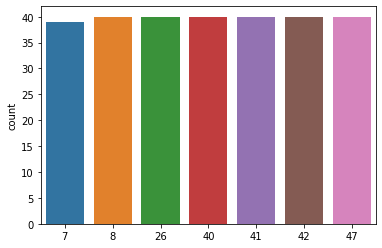

In [ ]:
sns.countplot(y_true_final)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


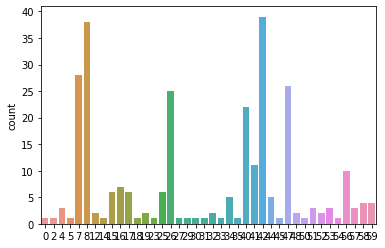

In [ ]:
sns.countplot(y_pred_final)

In [ ]:
print(classification_report(y_true_final,y_pred_final))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           7       1.00      0.72      0.84        39
           8       0.95      0.90      0.92        40
          12       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         0
          18       0.00      0.00      0.00         0
          19       0.00      0.00      0.00         0
          23       0.00      0.00      0.00         0
          25       0.00      0.00      0.00         0
          26       1.00      0.62      0.77        40
          27       0.00      0.00      0.00         0
          29       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
